In [1]:
import datetime

import pandas as pd
import numpy as np
from scipy.stats import chisquare, kstest
import matplotlib.pyplot as plt

# Upload data

In [2]:
data = pd.read_csv("collected_data.csv")

In [3]:
# Convert 'user_starred_repos_count' to string, extract the first digit, and then convert back to integer
data["first_digit"] = data["user_starred_repos_count"].astype(str).str[0].astype(int)

# Filter out rows where 'user_starred_repos_count' is 0
filtered_data = data[data["user_starred_repos_count"] > 0]

# Detect anomalies with Benford's Law


In [4]:
# Define the array of digits
digits = np.arange(1, 10)

# Calculate the expected distribution according to Benford's Law
expected_distribution = np.log10(1 + 1 / digits) * 100

### Using Chi-squared test

In [5]:
# Chi-squared Test for each repository
chi_squared_results = pd.DataFrame(columns=["repository", "chi2_statistic", "p_value"])

for repo, group in filtered_data.groupby("repository"):
    observed_frequencies = group["first_digit"].value_counts().sort_index().values
    expected_frequencies = (expected_distribution / 100) * len(group)

    chi2_statistic, p_value = chisquare(observed_frequencies, expected_frequencies)

    chi_squared_results = chi_squared_results._append(
        {"repository": repo, "chi2_statistic": chi2_statistic, "p_value": p_value},
        ignore_index=True,
    )

# Sort results by p_value to see repositories that most likely don't follow Benford's distribution at the top
chi_squared_results = chi_squared_results.sort_values(by="p_value")
chi_squared_results.head()

,repository,chi2_statistic,p_value
80,worktool,1201.623042,4.276668e-254
10,File-Sharing-Bot,271.532324,4.649002e-54
9,FXMinerProxy,248.555951,3.485919e-49
21,app-monorepo,139.946272,2.434696e-26
44,matrixone,121.341095,1.752041e-22


In [6]:
# Count the number of repositories with p-value less than 0.05
chi_repos_below_threshold = chi_squared_results[chi_squared_results["p_value"] < 0.05]

print(
    f"Out of {chi_squared_results.shape[0]} repositories, we rulled out {chi_repos_below_threshold.shape[0]} with chi-squared test"
)

Out of 81 repositories, we rulled out 16 with chi-squared test


### Using Kolmogorov–Smirnov test

In [7]:
# Kolmogorov-Smirnov Test for each repository
ks_results = pd.DataFrame(columns=["repository", "ks_statistic", "p_value"])

for repo, group in filtered_data.groupby("repository"):
    observed_frequencies = (
        group["first_digit"].value_counts(normalize=True).sort_index().cumsum().values
    )
    ks_statistic, p_value = kstest(observed_frequencies, "uniform", args=(0, 1))

    ks_results = ks_results._append(
        {"repository": repo, "ks_statistic": ks_statistic, "p_value": p_value},
        ignore_index=True,
    )

# Sort results by p_value to see repositories that most likely don't follow Benford's distribution at the top
ks_results = ks_results.sort_values(by="p_value")

ks_results.head()

,repository,ks_statistic,p_value
80,worktool,0.548487,0.004549
10,File-Sharing-Bot,0.546396,0.004777
3,BetterNCM-Installer,0.486055,0.017590
9,FXMinerProxy,0.435873,0.045157
66,sunflower-land,0.427472,0.052228


In [9]:
# Count the number of repositories with p-value less than 0.05
ks_repos_below_threshold = ks_results[ks_results["p_value"] < 0.05]

print(
    f"Out of {ks_results.shape[0]} repositories,  we rulled out {ks_repos_below_threshold.shape[0]} with Kolmogorov–Smirnov test"
)

Out of 81 repositories,  we rulled out 4 with Kolmogorov–Smirnov test


### Pick repositories rulled out by Kolmogorov–Smirnov

In [10]:
lowest_pvalue_repos = ks_repos_below_threshold["repository"].tolist()

### Pick 4 random repositories with p-value higher than 0.05 in Chi-squared test

In [11]:
random_high_pvalue_repos = (
    chi_squared_results[chi_squared_results["p_value"] > 0.05]
    .sample(4)["repository"]
    .tolist()
)

# Plot results

In [12]:
# Function to plot Benford's distribution for a given repository
def plot_benford_distribution(repo, ax):
    repo_data = filtered_data[filtered_data["repository"] == repo]
    actual_distribution = (
        repo_data["first_digit"].value_counts(normalize=True).sort_index() * 100
    )
    ax.bar(
        actual_distribution.index, actual_distribution.values, alpha=0.7, label="Actual"
    )
    ax.plot(
        digits,
        expected_distribution,
        marker="o",
        linestyle="-",
        color="r",
        label="Expected (Benford)",
    )
    ax.set_title(repo)
    ax.set_xlabel("First Digit")
    ax.set_ylabel("Percentage")
    ax.legend()

## Plot for detected repositories

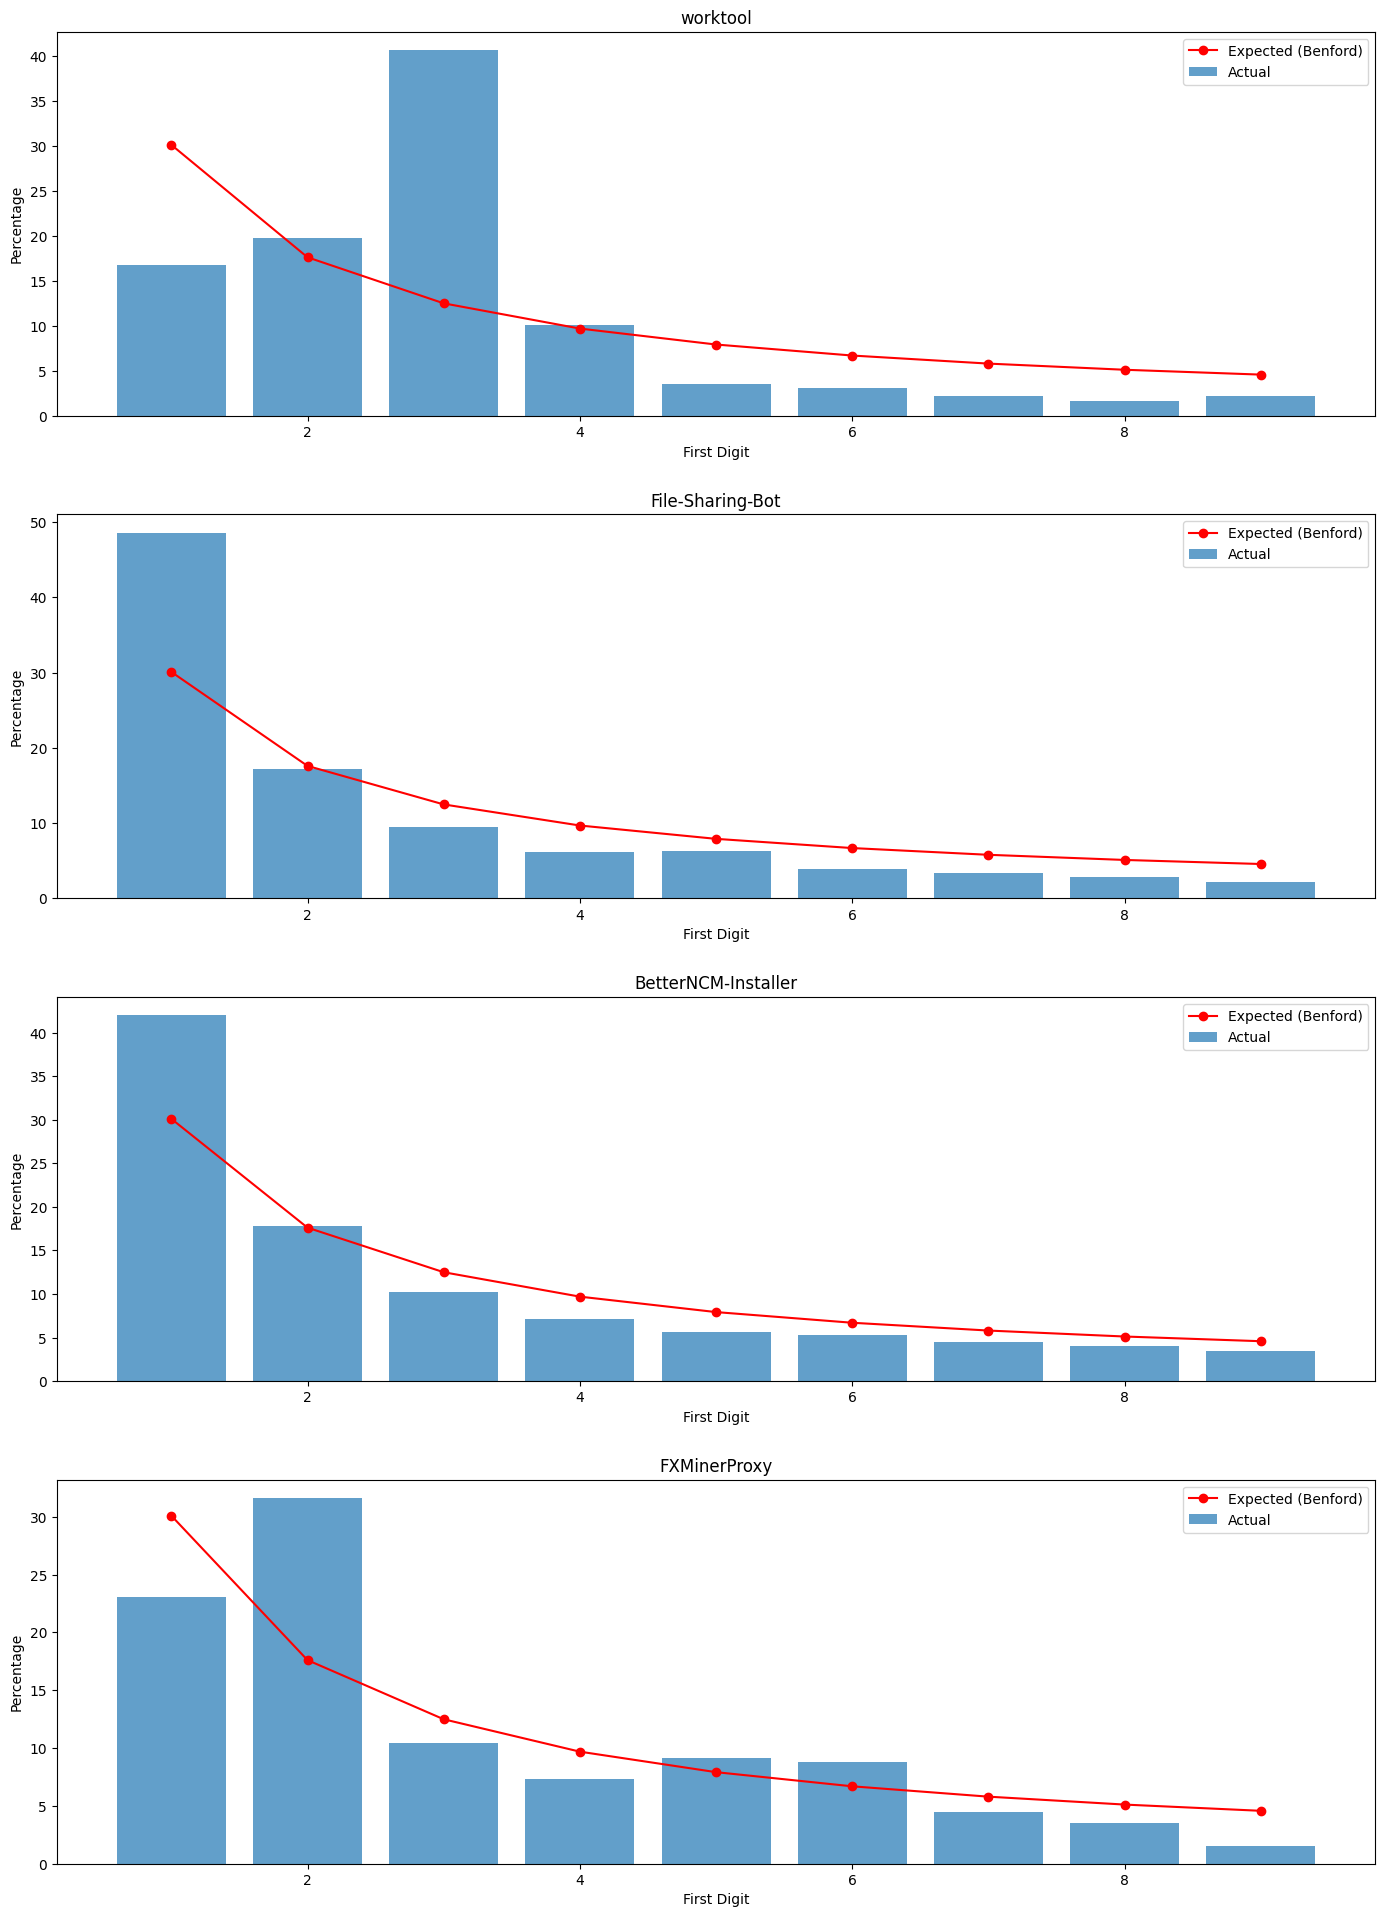

In [13]:
fig, axes = plt.subplots(nrows=4, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for repo, ax in zip(lowest_pvalue_repos, axes.ravel()):
    plot_benford_distribution(repo, ax)

plt.show()

## Plot for random repositories

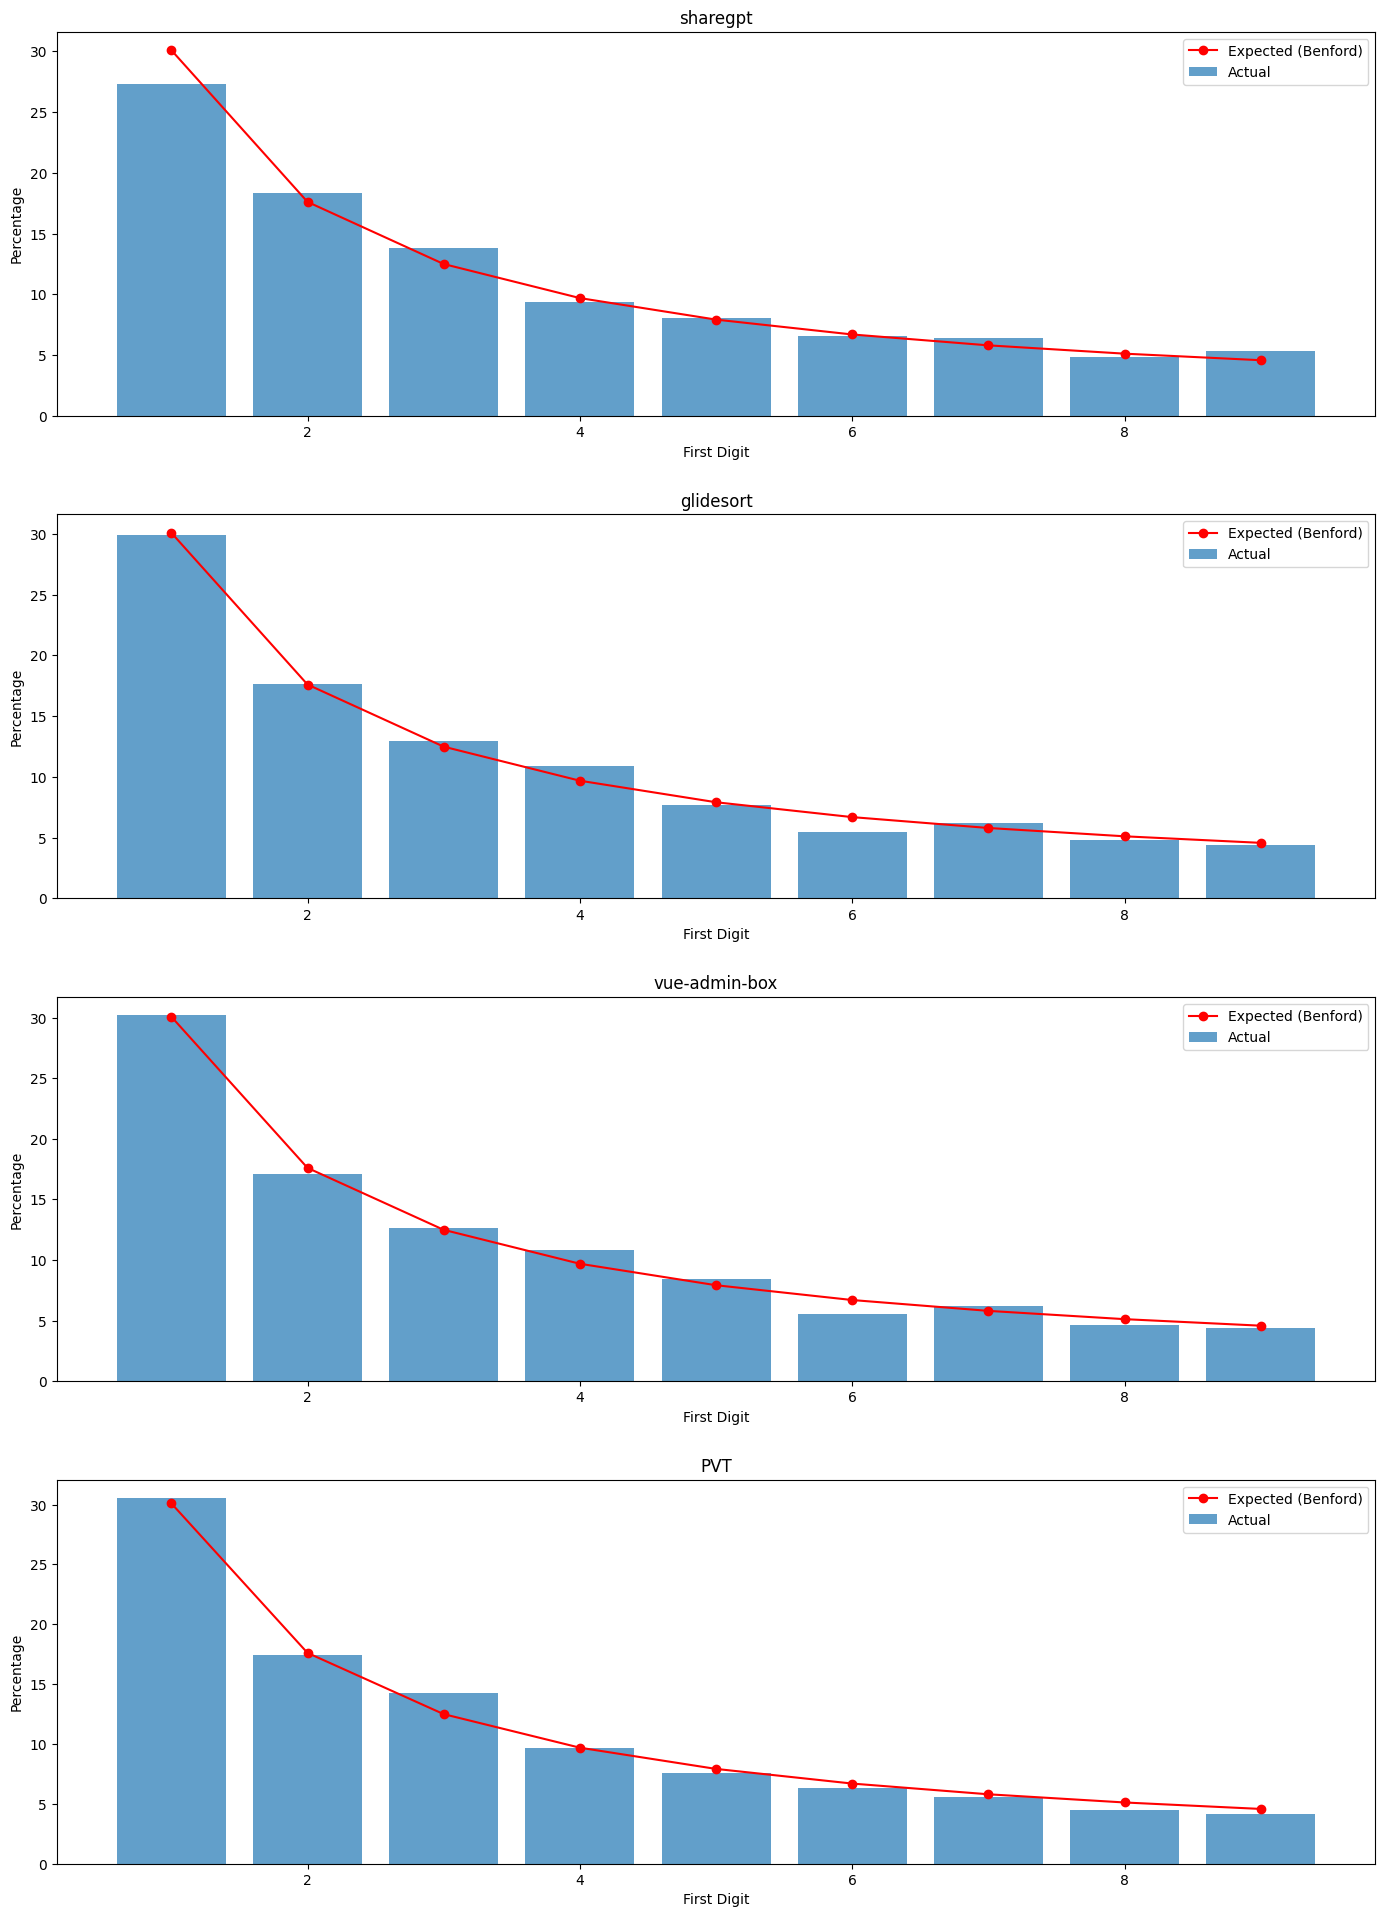

In [14]:
fig, axes = plt.subplots(nrows=4, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for repo, ax in zip(random_high_pvalue_repos, axes.ravel()):
    plot_benford_distribution(repo, ax)

plt.show()

# Plots for rapid growths

In [15]:
# Convert 'starred_at' column to datetime
data["starred_at"] = pd.to_datetime(data["starred_at"])

# Resample the data to weekly averages
weekly_data = (
    data.groupby(["repository", pd.Grouper(key="starred_at", freq="W-MON")])
    .size()
    .reset_index(name="weekly_stargazers")
)
weekly_data["cumulative_stargazers"] = weekly_data.groupby("repository")[
    "weekly_stargazers"
].cumsum()

In [16]:
# Function to plot rapid growth of stargazers for a given repository using weekly data
def plot_rapid_growth_weekly(repo, ax):
    repo_data = weekly_data[weekly_data["repository"] == repo].copy()

    # Calculate the 3-week moving average of stargazers for the repository
    repo_data["moving_average"] = (
        repo_data["cumulative_stargazers"].rolling(window=3).mean()
    )

    # Calculate the standard deviation for the moving average for the repository
    repo_data["std_dev"] = repo_data["cumulative_stargazers"].rolling(window=3).std()

    # Calculate an upper bound as moving average + 2 * standard deviation
    repo_data["upper_bound"] = repo_data["moving_average"] + 2 * repo_data["std_dev"]

    ax.plot(
        repo_data["starred_at"],
        repo_data["cumulative_stargazers"],
        label="Cumulative Stargazers",
        color="b",
    )
    ax.plot(
        repo_data["starred_at"],
        repo_data["moving_average"],
        label="Moving Average",
        color="g",
    )
    ax.plot(
        repo_data["starred_at"],
        repo_data["upper_bound"],
        label="Upper Bound (Rapid Growth)",
        color="r",
        linestyle="--",
    )
    ax.set_title(repo)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Stargazers")
    ax.legend()

## Plots for detected repositories

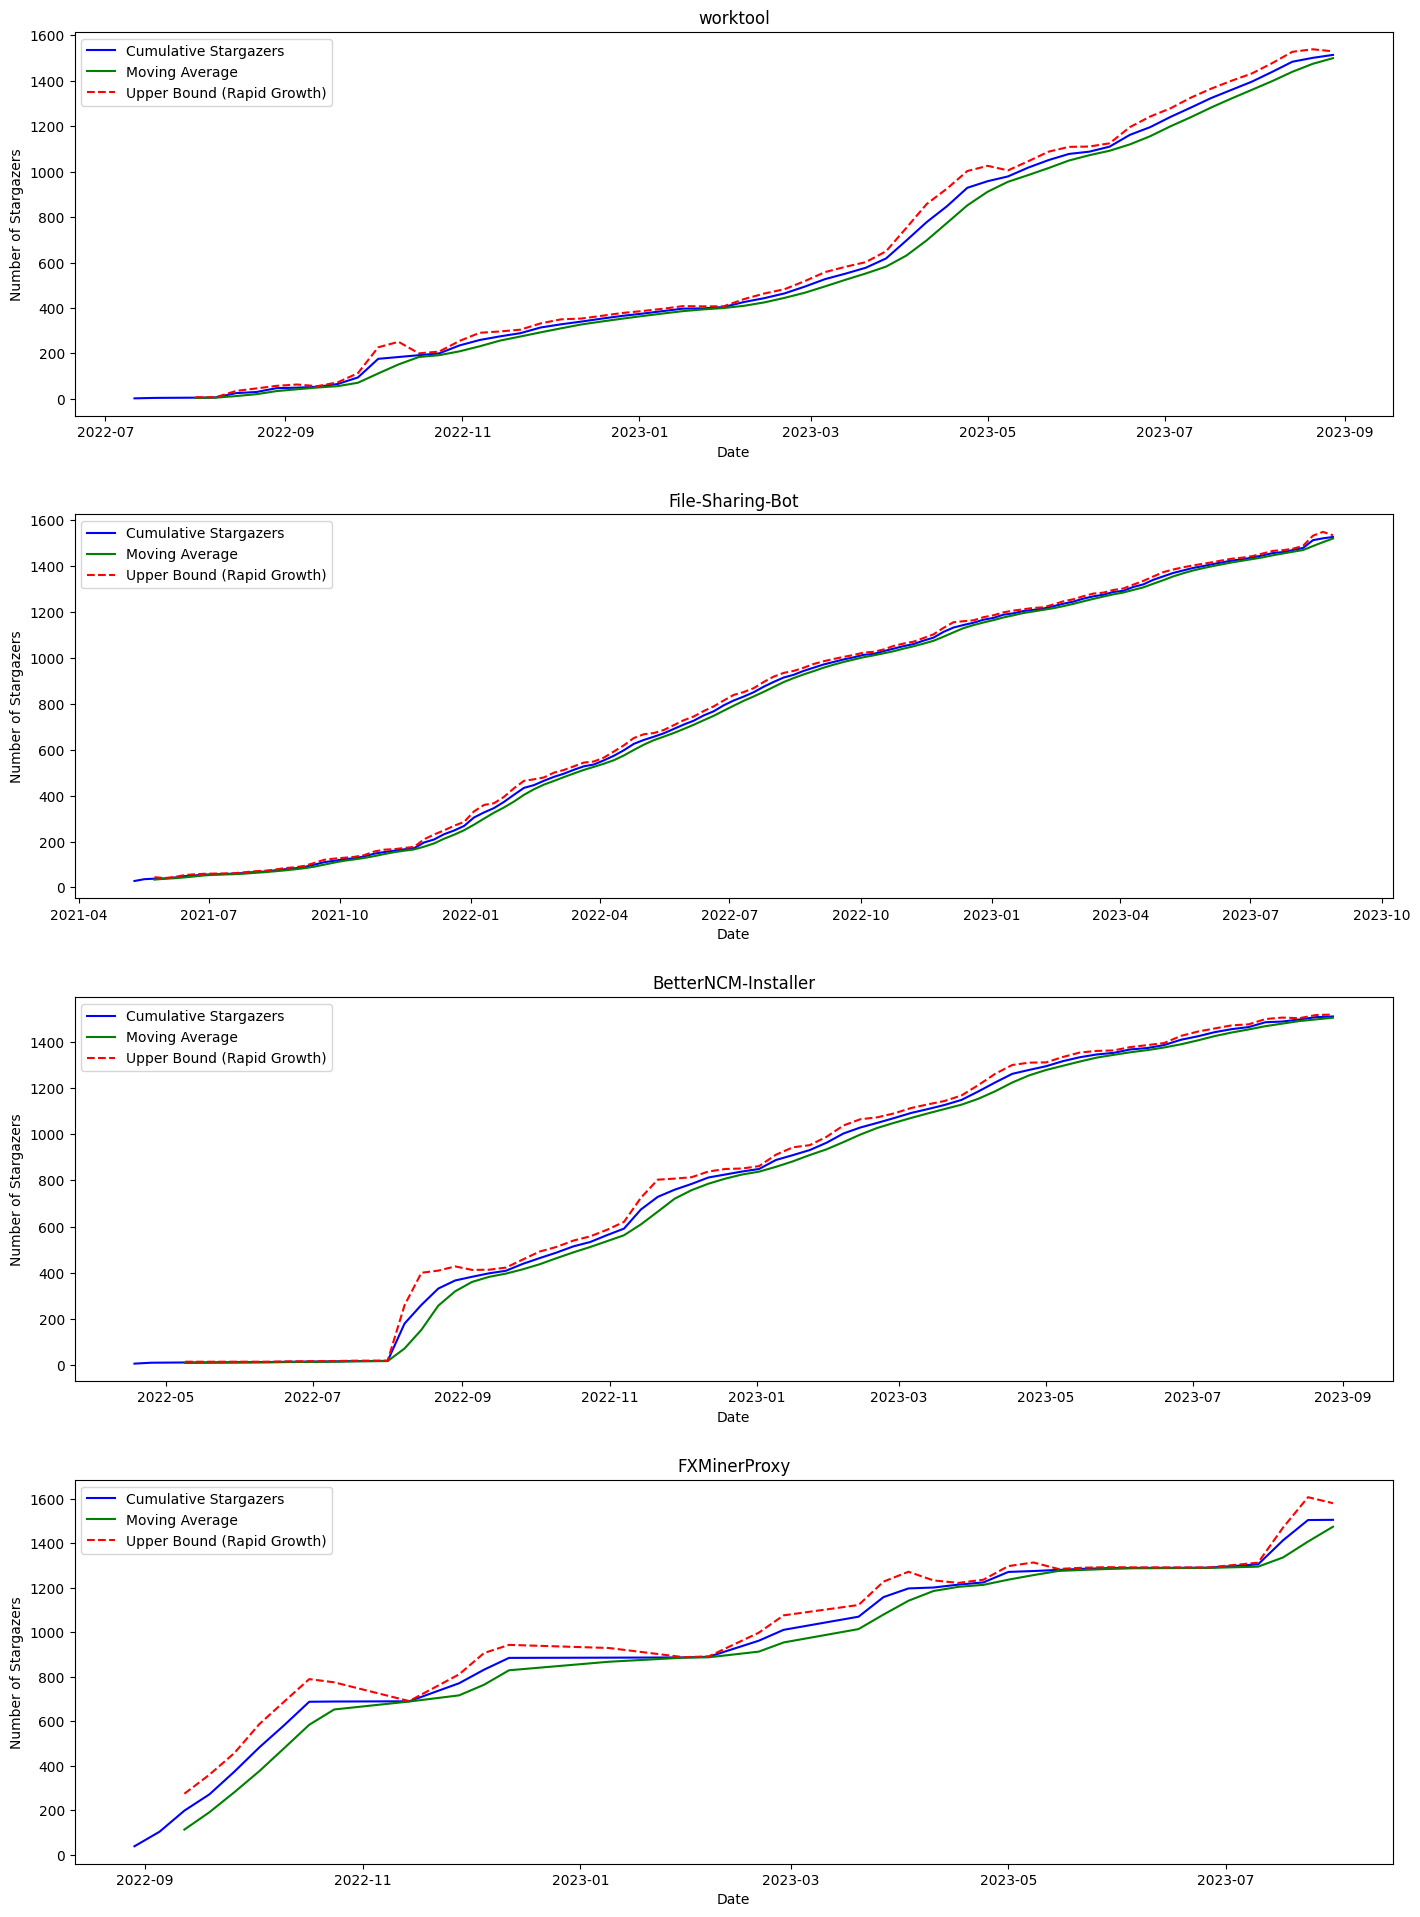

In [17]:
# Plot rapid growth of stargazers for detected repositories using weekly data
fig, axes = plt.subplots(nrows=4, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for repo, ax in zip(lowest_pvalue_repos, axes.ravel()):
    plot_rapid_growth_weekly(repo, ax)

plt.show()

## Plots for random repositories

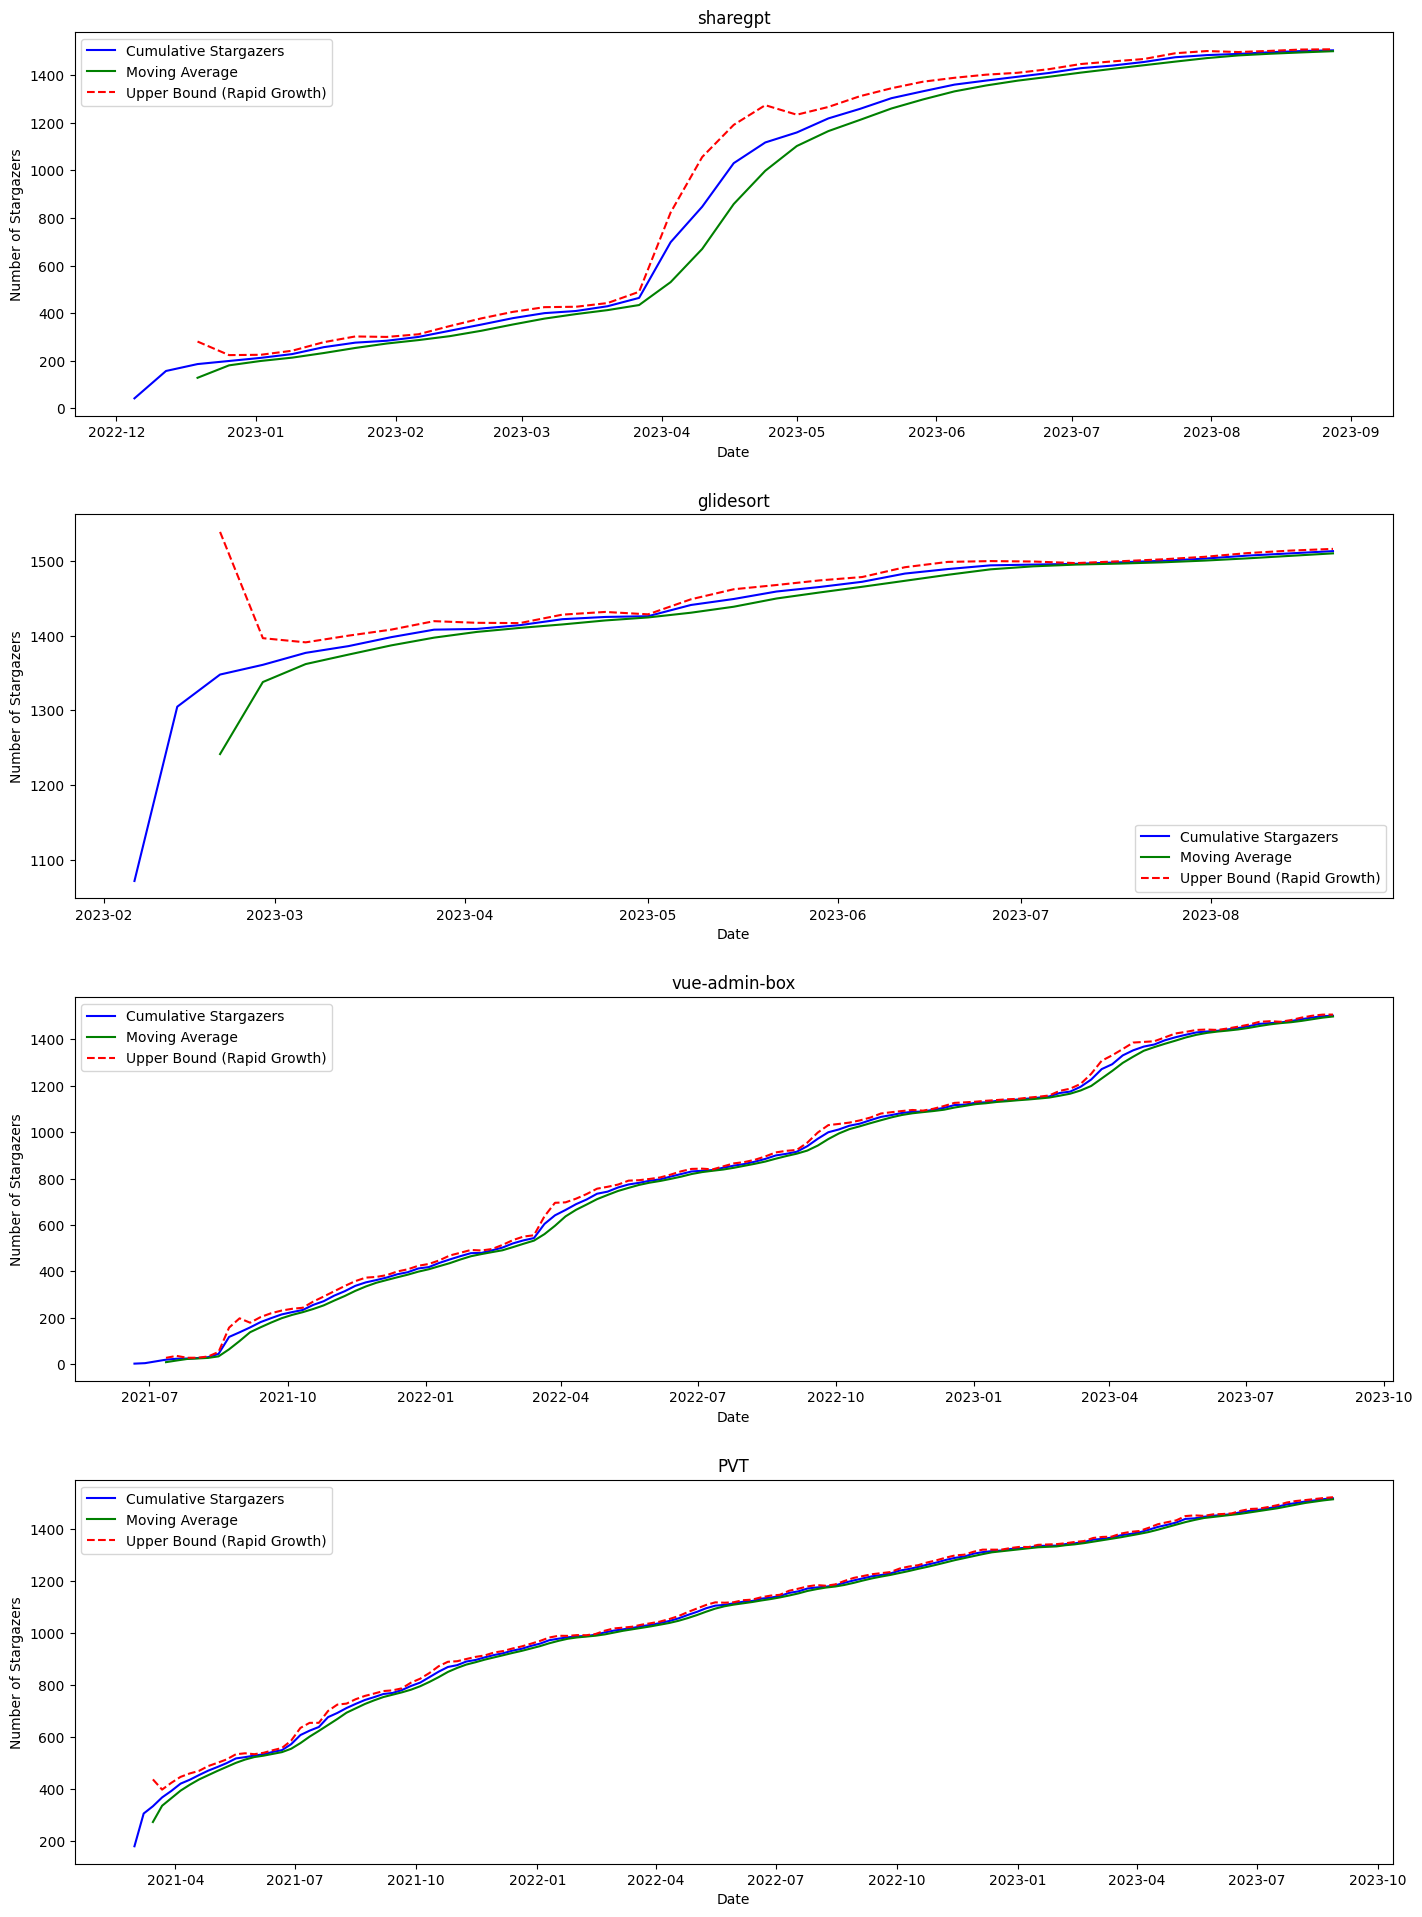

In [18]:
# Plot rapid growth of stargazers for the random repositories using weekly data
fig, axes = plt.subplots(nrows=4, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for repo, ax in zip(random_high_pvalue_repos, axes.ravel()):
    plot_rapid_growth_weekly(repo, ax)

plt.show()

# Plots for weekly growth

In [19]:
# Function to plot weekly growth of stargazers for a given repository
def plot_weekly_growth(repo, ax):
    repo_data = weekly_data[weekly_data["repository"] == repo]
    ax.plot(
        repo_data["starred_at"],
        repo_data["weekly_stargazers"],
        marker="o",
        linestyle="-",
    )
    ax.set_title(repo)
    ax.set_xlabel("Date")
    ax.set_ylabel("Weekly Stargazers")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Annotate significant spikes
    z_scores = (
        repo_data["weekly_stargazers"] - repo_data["weekly_stargazers"].mean()
    ) / repo_data["weekly_stargazers"].std()
    spikes = repo_data[z_scores > 2]
    for idx, row in spikes.iterrows():
        ax.annotate(
            f"{int(row['weekly_stargazers'])}",
            (row["starred_at"], row["weekly_stargazers"]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
        )

## Plots for detected repos

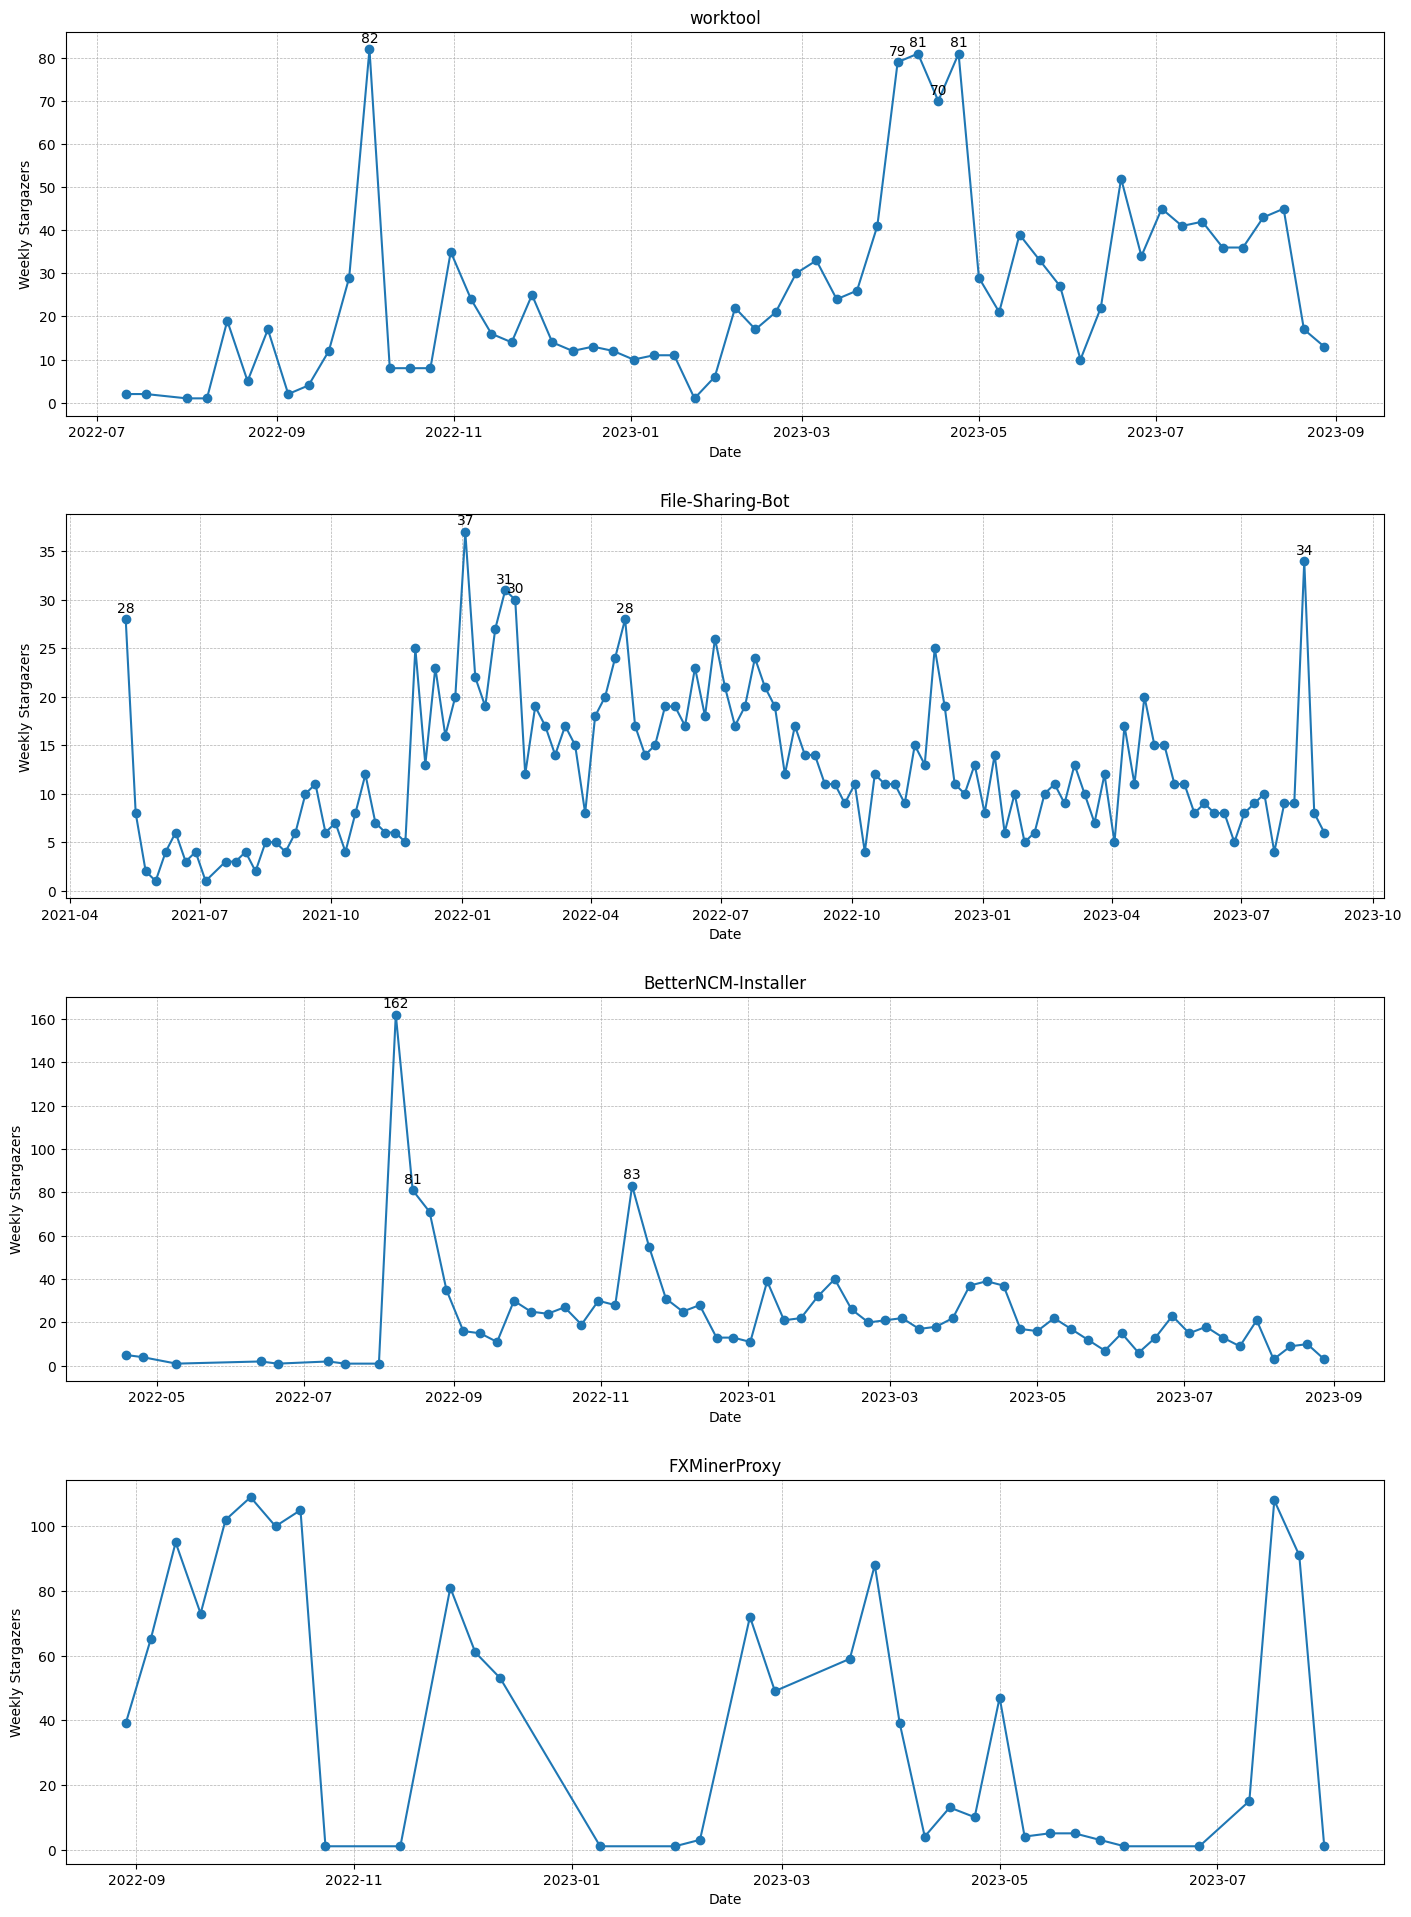

In [20]:
# Plot weekly growth of stargazers for detected repositories
fig, axes = plt.subplots(nrows=4, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for repo, ax in zip(lowest_pvalue_repos, axes.ravel()):
    plot_weekly_growth(repo, ax)

plt.show()

## Plots for random repos

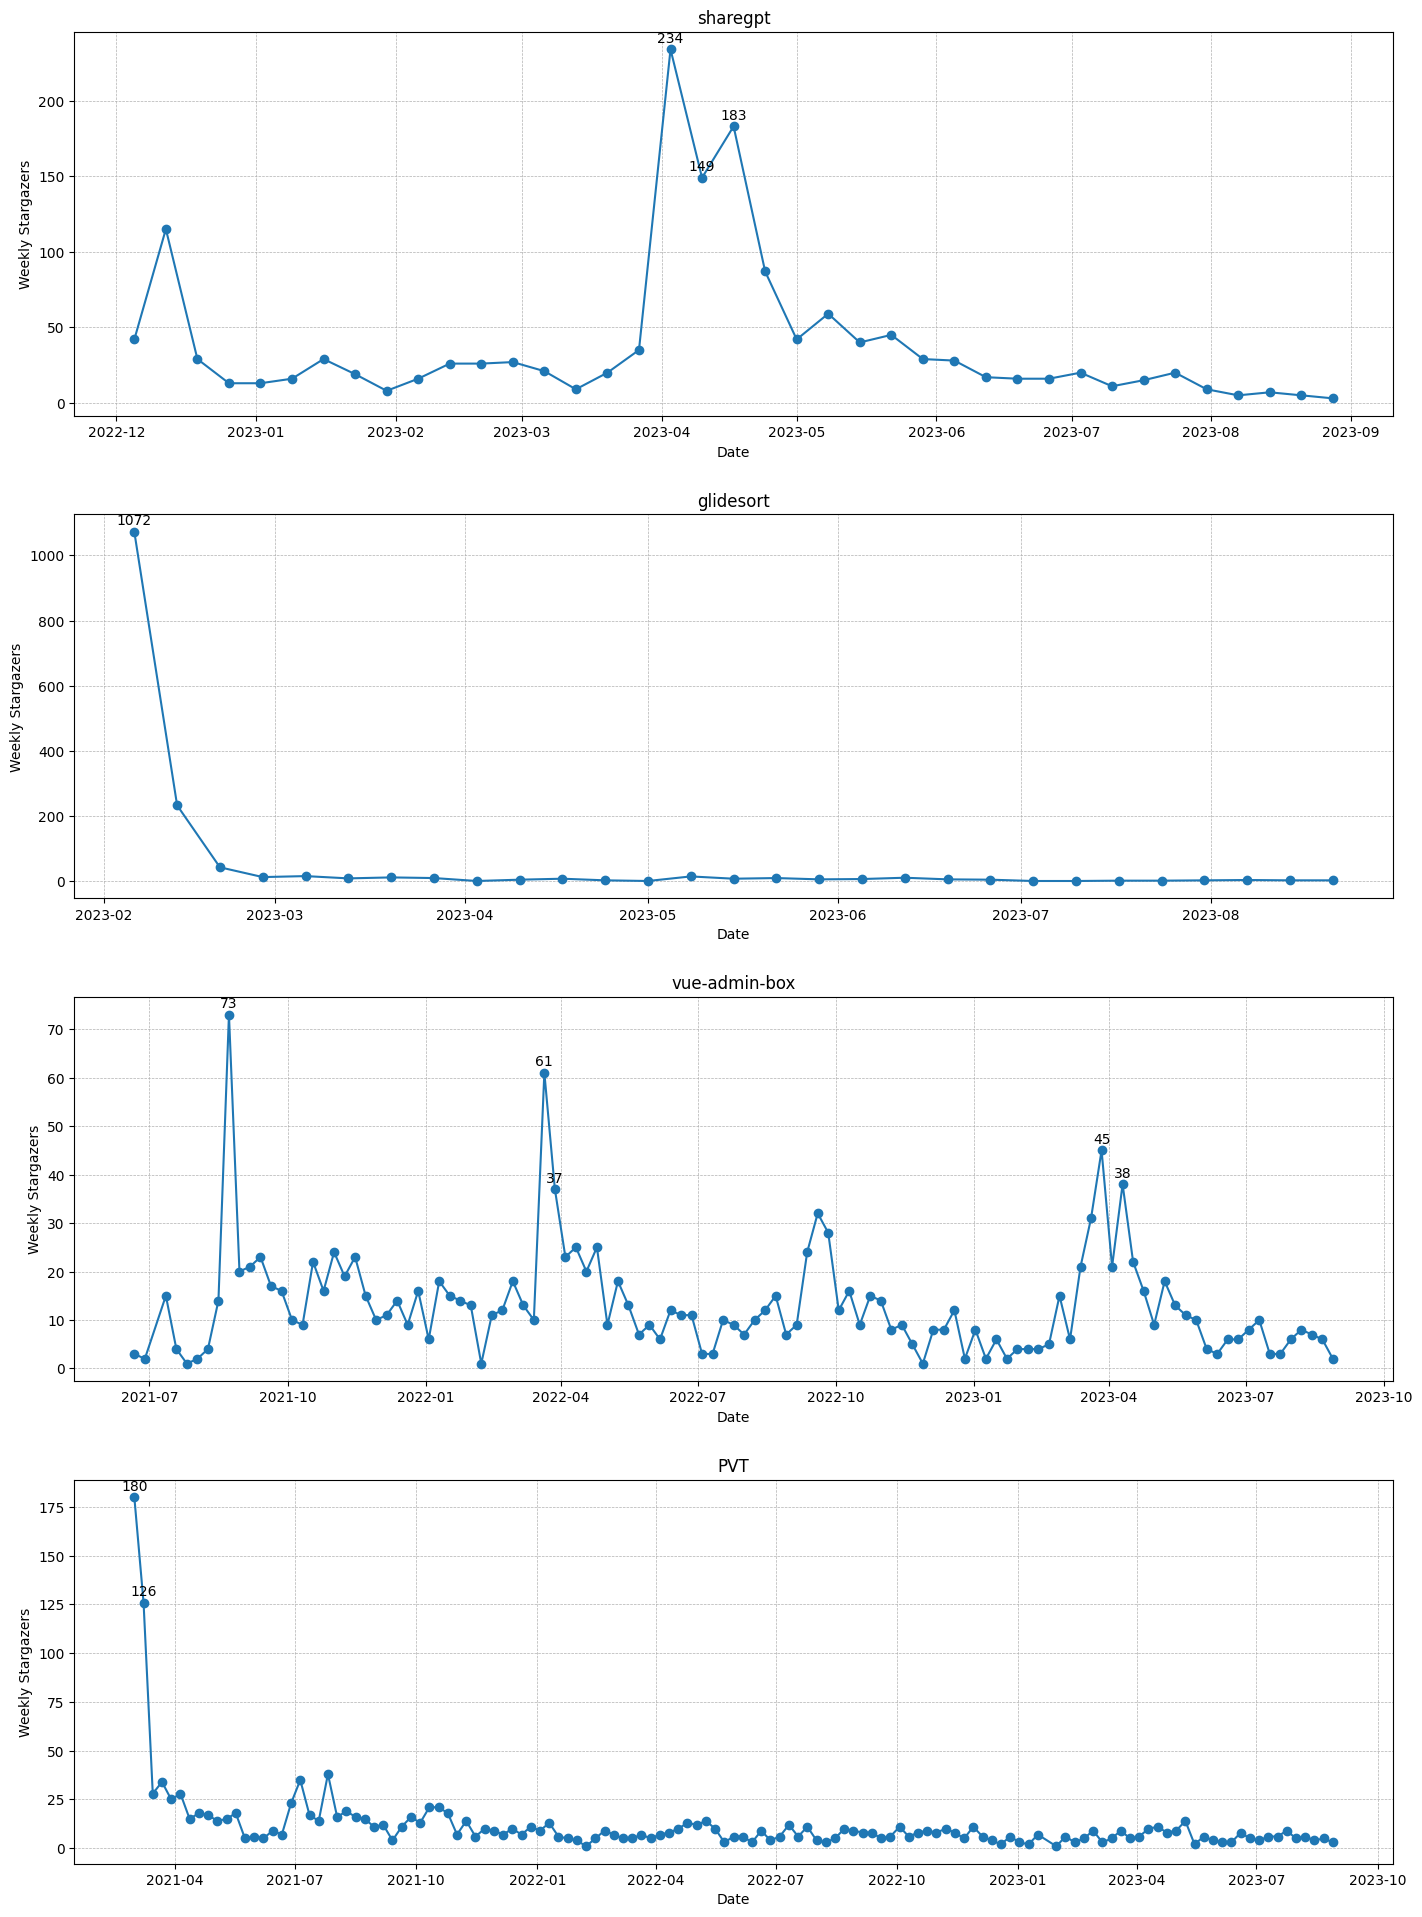

In [21]:
# Plot weekly growth of stargazers for the random repositories
fig, axes = plt.subplots(nrows=4, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for repo, ax in zip(random_high_pvalue_repos, axes.ravel()):
    plot_weekly_growth(repo, ax)

plt.show()